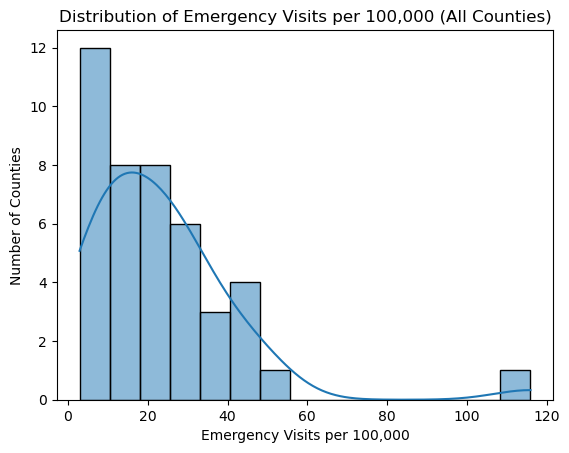

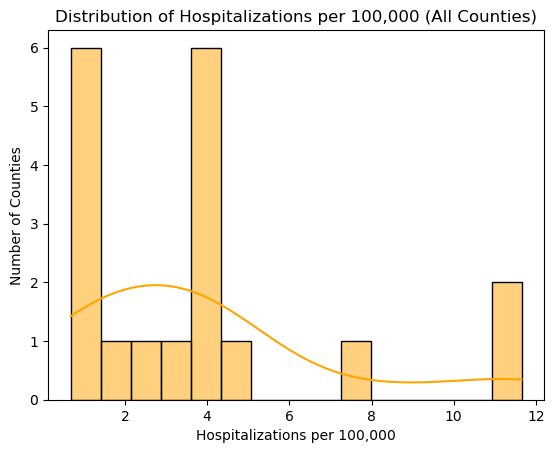

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_excel('County_Statistics_with_Temp.xlsx')

# Emergency Visits
sns.histplot(df['Emergency Visits / 100000'], bins=15, kde=True)
plt.title('Distribution of Emergency Visits per 100,000 (All Counties)')
plt.xlabel('Emergency Visits per 100,000')
plt.ylabel('Number of Counties')
plt.show()

# Hospitalizations
sns.histplot(df['Hospitalizations / 100000'], bins=15, kde=True, color='orange')
plt.title('Distribution of Hospitalizations per 100,000 (All Counties)')
plt.xlabel('Hospitalizations per 100,000')
plt.ylabel('Number of Counties')
plt.show()
#Notes: A few counties have high ER visit and that corresponds to high heat counties like Imperial County
# Same with hospitalization

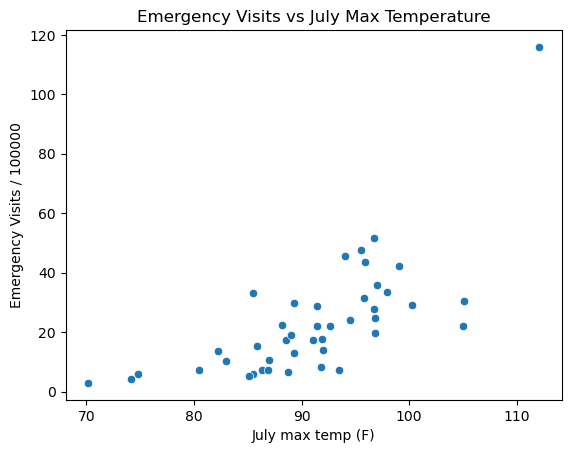

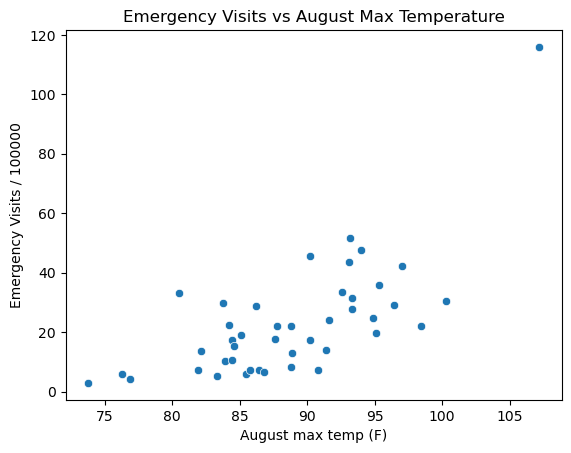

In [2]:
sns.scatterplot(
    data=df,
    x='July max temp (F)',
    y='Emergency Visits / 100000'
)
plt.title('Emergency Visits vs July Max Temperature')
plt.show()
# Perfect! More hot means more ER visit. Are the dates same? If yes, then this is a trend.

sns.scatterplot(
    data=df,
    x='August max temp (F)',
    y='Emergency Visits / 100000'
)
plt.title('Emergency Visits vs August Max Temperature')
plt.show()
#same trend for August

In [3]:
df[['Emergency Visits / 100000', 'August max temp (F)']].corr()


,Emergency Visits / 100000,August max temp (F)
Emergency Visits / 100000,1.000000,0.687191
August max temp (F),0.687191,1.000000


In [4]:
df[['Emergency Visits / 100000', 'July max temp (F)']].corr()
#Looking at the correlations, it look like we get up to 0.7 correlation with the July temperature data
#Looking at the graphs, I am not sure if a linear fitting is best. Lets try other types of fitting 

#I am considering a piecewise relationship, since there might be a threshold temperature
#Below threshold temperature, no unusual risk of heat stroke 
# https://www.dir.ca.gov/dosh/heatillnessinvestigations-2006.pdf 
# https://www.lni.wa.gov/safety-health/safety-training-materials/workshops-events/beheatsmart#questions-and-answers
# Both of these suggest to set the threshold to 80 F 

,Emergency Visits / 100000,July max temp (F)
Emergency Visits / 100000,1.000000,0.703606
July max temp (F),0.703606,1.000000


In [5]:
df.sample(4)

,County,Emergency Visits / 100000,Hospitalizations / 100000,Energy Burden % of Income,Imperviousness,Park within 1/2 Mile,Hospital Beds / 10000,Housing Built before 1980,Housing Insecurity,Lack of Reliable Transportation,% w/o Internet,Utility Services Threat,July max temp (F),August max temp (F),July CDD,August CDD
42,Santa Clara,7.12,1.04,1.0%,12.5%,93.0%,22.70,62.74%,7.9%,5.7%,3.7%,3.8%,86.9,85.8,237,221
18,Los Angeles,8.35,1.33,1.6%,17.7%,82.8%,24.78,73.55%,16.0%,9.6%,7.5%,7.4%,91.8,88.8,431,340
16,Lake,22.00,NaN,4.6%,0.9%,45.6%,9.09,50.20%,15.0%,10.3%,13.4%,8.3%,91.4,88.8,354,298
47,Solano,14.05,NaN,2.0%,6.5%,75.1%,33.51,47.47%,14.1%,8.9%,4.9%,7.4%,92.0,91.4,317,336


In [6]:
df_Emergengy = df.dropna(subset=['Emergency Visits / 100000'])
df_Emergengy = df_Emergengy.drop('Hospitalizations / 100000', axis=1)



In [12]:
import numpy as np
# original series from your dataframe
x_july = df_Emergengy['July max temp (F)']
x_august = df_Emergengy['August max temp (F)']
# as numpy arrays
x_july_np = x_july.to_numpy(dtype=float)
x_august_np = x_august.to_numpy(dtype=float)
# elementwise max: np.fmax returns the non-NaN value when one side is NaN
x_max_np = np.fmax(x_july_np, x_august_np)
y = df_Emergengy['Emergency Visits / 100000']
y_np = y.to_numpy()
y_list = y.tolist()


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

def fit_linear_with_intercept_enforced(x, y, lower, upper,title, x_thresh=80.0, y_min=None,
                                       plot=True, max_nfev=20000):
    """
    Fit y = m * x + b to points with x >= x_thresh, enforcing b so that y(x_thresh) = y_min.
    y_min defaults to the min of the original y array (ignoring NaNs) if not provided.

    Args:
        x, y: 1-D array-like (will be converted to numpy arrays). NaNs are handled.
        lower, upper: bounds for parameter vector [m]. Each must be scalar or length-1 sequence.
        x_thresh: threshold where intercept is enforced (default 80.0).
        y_min: value y(x_thresh) should equal. If None, uses np.nanmin(y) from the original y.
        plot: if True, show a scatter + fitted line plot.
        max_nfev: max evaluations for least_squares.

    Returns:
        dict with keys: m, b, success, message, rmse, r2, res (least_squares result), x_fit_mask, x, y, y_pred
    """
    x_arr = np.asarray(x, dtype=float)
    y_arr = np.asarray(y, dtype=float)

    # determine y_min if not provided (use full original y array)
    if y_min is None:
        y_min = np.nanmin(y_arr)

    # mask for x >= threshold and non-NaN pairs
    mask = (x_arr >= x_thresh) & ~np.isnan(x_arr) & ~np.isnan(y_arr)
    x_sel = x_arr[mask]
    y_sel = y_arr[mask]

    if x_sel.size == 0:
        raise ValueError(f"No data points with x >= {x_thresh}")

    # model: y = m * x + b with b = y_min - m * x_thresh
    def model_given_m(params, xvals):
        m = params[0]
        b = y_min - m * x_thresh
        return m * xvals + b

    def residuals(params, xvals, yvals):
        return model_given_m(params, xvals) - yvals

    # initial guess for m: slope from simple linear fit on selected points if possible
    try:
        slope_init = np.polyfit(x_sel, y_sel, 1)[0]
        m_init = slope_init
    except Exception:
        m_init = (np.nanmean(y_sel) / np.nanmean(x_sel)) if np.nanmean(x_sel) != 0 else 1.0

    init = np.atleast_1d(np.array([m_init], dtype=float))

    # ensure bounds are arrays of length 1
    lower_arr = np.atleast_1d(np.array(lower, dtype=float))
    upper_arr = np.atleast_1d(np.array(upper, dtype=float))
    if lower_arr.size != 1 or upper_arr.size != 1:
        raise ValueError("lower and upper must be scalar or length-1 sequences for parameter [m].")

    res = least_squares(residuals, init, args=(x_sel, y_sel), bounds=(lower_arr, upper_arr),
                        ftol=1e-9, xtol=1e-9, gtol=1e-9, max_nfev=max_nfev)

    m_fit = res.x[0]
    b_fit = y_min - m_fit * x_thresh

    # diagnostics on selected points
    y_pred_sel = model_given_m([m_fit], x_sel)
    rss = np.sum((y_sel - y_pred_sel) ** 2)
    rmse = np.sqrt(rss / len(y_sel))
    r2 = 1 - rss / np.sum((y_sel - np.mean(y_sel)) ** 2) if np.sum((y_sel - np.mean(y_sel)) ** 2) != 0 else np.nan

    # optional plot (shows only selected points and fitted line)
    if plot:
        xs = np.linspace(np.nanmin(x_sel) - 1, np.nanmax(x_sel) + 1, 400)
        ys = m_fit * xs + b_fit
        plt.figure(figsize=(8,6))
        plt.scatter(x_sel, y_sel, label='data (x >= {:.1f})'.format(x_thresh), c='C0')
        plt.plot(xs, ys, 'r-', lw=2, label=f'fit: y = {m_fit:.4g}*x + {b_fit:.4g}')
        plt.scatter([x_thresh], [y_min], color='black', zorder=5, label=f'y({x_thresh}) enforced = {y_min:.3g}')
        plt.xlabel(f'x (>= {x_thresh})')
        plt.ylabel('y')
        plt.legend()
        plt.title('Linear fit for '+title)
        plt.show()

    return {
        'm': m_fit,
        'b': b_fit,
        'success': res.success,
        'message': res.message,
        'rmse': rmse,
        'r2': r2,
        'res': res,
        'x_fit_mask': mask,
        'x_selected': x_sel,
        'y_selected': y_sel,
        'y_pred_selected': y_pred_sel
    }

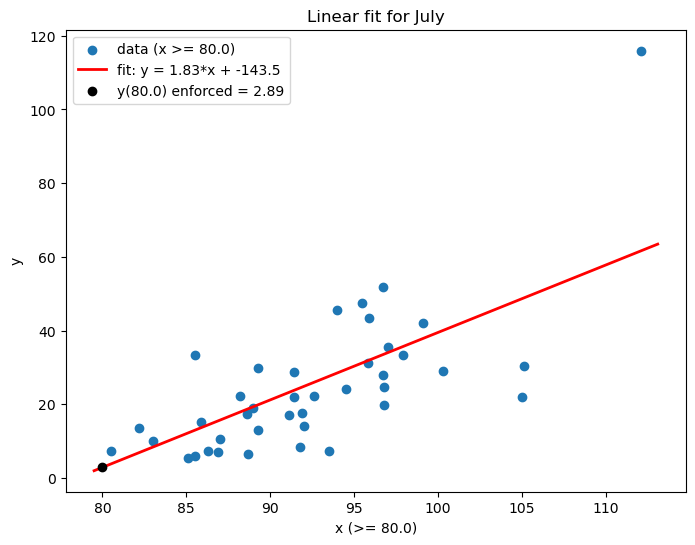

m = 1.8299828613539062 b = -143.50862890831252 RMSE = 13.652232598276568 R2 = 0.4944704340342806


In [25]:
# x_all and y_all come from your preprocessed arrays / lists
lower = [0]   # lower bound for m
upper = [ 1e6]   # upper bound for m

out = fit_linear_with_intercept_enforced(x_july_np, y_list, lower, upper, title = 'July',
                                         x_thresh=80.0, y_min=np.nanmin(y_list), plot=True)

print("m =", out['m'], "b =", out['b'], "RMSE =", out['rmse'], "R2 =", out['r2'])


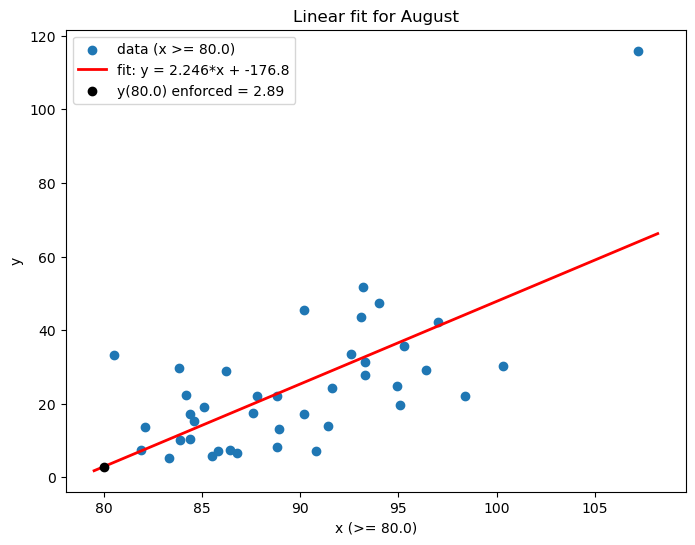

m = 2.2458790179878445 b = -176.78032143902757 RMSE = 14.243519105872194 R2 = 0.4497325704949702


In [28]:
# x_all and y_all come from your preprocessed arrays / lists
lower = [0]   # lower bound for m
upper = [ 1e6]   # upper bound for m

out = fit_linear_with_intercept_enforced(x_august_np, y_list, lower, upper, title = 'August',
                                         x_thresh=80.0, y_min=np.nanmin(y_list), plot=True)

print("m =", out['m'], "b =", out['b'], "RMSE =", out['rmse'], "R2 =", out['r2'])


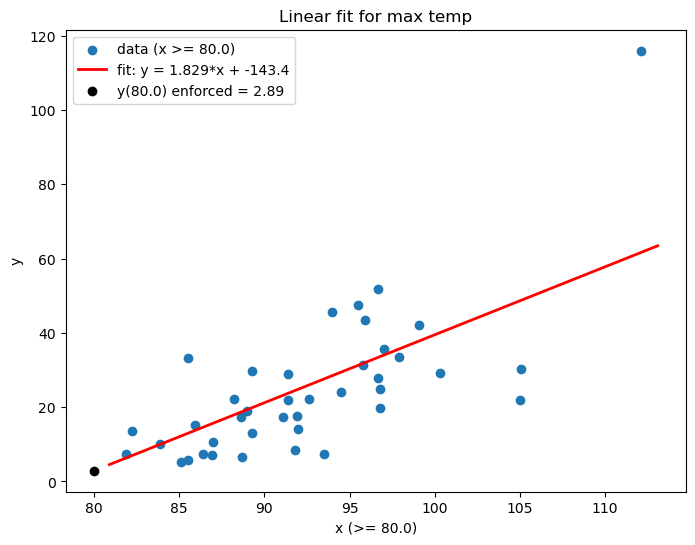

m = 1.8291274417820222 b = -143.4401953425618 RMSE = 13.641474573817337 R2 = 0.4952668395473906


In [27]:
# x_all and y_all come from your preprocessed arrays / lists
lower = [0]   # lower bound for m
upper = [ 1e6]   # upper bound for m

out = fit_linear_with_intercept_enforced(x_max_np, y_list, lower, upper, title = 'max temp',
                                         x_thresh=80.0, y_min=np.nanmin(y_list), plot=True)

print("m =", out['m'], "b =", out['b'], "RMSE =", out['rmse'], "R2 =", out['r2'])


In [57]:
#Ok, now I have an acceptable relationship between temperature and emergency visit. 
#August has a lower 
#Now I need to normalize this
#We can use this relationship, and subtract it, to get our residual plot 
#Time to redo EDA, but this time with residuals instead 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

sns.set_style("whitegrid")
county_df = pd.read_excel("data/County_Statistics_with_Temp.xlsx")
#dropping hospitalization
county_df = county_df.drop('Hospitalizations / 100000', axis=1)
#drop na to drop rows with empty values for emergency visits
#our target is emergency visits for this analysis

county_df = county_df.dropna()
county_df.head()
#remove all instances of '%'
county_df['Park within 1/2 Mile'] = county_df['Park within 1/2 Mile'].str.removesuffix('%')
county_df['Imperviousness'] = county_df['Imperviousness'].str.removesuffix('%')
county_df['Energy Burden % of Income'] = county_df['Energy Burden % of Income'].str.removesuffix('%')
county_df['Housing Built before 1980'] = county_df['Housing Built before 1980'].str.removesuffix('%')
county_df['Housing Insecurity'] = county_df['Housing Insecurity'].str.removesuffix('%')
county_df['Lack of Reliable Transportation'] = county_df['Lack of Reliable Transportation'].str.removesuffix('%')
county_df['% w/o Internet'] = county_df['% w/o Internet'].str.removesuffix('%')
county_df['Utility Services Threat'] = county_df['Utility Services Threat'].str.removesuffix('%')

#convert to float
county_df['Park within 1/2 Mile'] = county_df['Park within 1/2 Mile'].astype(float)
county_df['Imperviousness'] = county_df['Imperviousness'].astype(float)
county_df['Energy Burden % of Income'] = county_df['Energy Burden % of Income'].astype(float)
county_df['Hospital Beds / 10000'] = county_df['Hospital Beds / 10000'].astype(float)
county_df['Housing Built before 1980'] = county_df['Housing Built before 1980'].astype(float)
county_df['Housing Insecurity'] = county_df['Housing Insecurity'].astype(float)
county_df['Lack of Reliable Transportation'] = county_df['Lack of Reliable Transportation'].astype(float)
county_df['% w/o Internet'] = county_df['% w/o Internet'].astype(float)
county_df['Utility Services Threat'] = county_df['Utility Services Threat'].astype(float)


county_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 43 entries, 0 to 57
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   County                           43 non-null     object 
 1   Emergency Visits / 100000        43 non-null     float64
 2   Energy Burden % of Income        43 non-null     float64
 3   Imperviousness                   43 non-null     float64
 4   Park within 1/2 Mile             43 non-null     float64
 5   Hospital Beds / 10000            43 non-null     float64
 6   Housing Built before 1980        43 non-null     float64
 7   Housing Insecurity               43 non-null     float64
 8   Lack of Reliable Transportation  43 non-null     float64
 9   % w/o Internet                   43 non-null     float64
 10  Utility Services Threat          43 non-null     float64
 11  July max temp (F)                43 non-null     float64
 12  August max temp (F)     

In [81]:
county_df.sample()

,County,Emergency Visits / 100000,Energy Burden % of Income,Imperviousness,Park within 1/2 Mile,Hospital Beds / 10000,Housing Built before 1980,Housing Insecurity,Lack of Reliable Transportation,% w/o Internet,Utility Services Threat,July max temp (F),August max temp (F),July CDD,August CDD
39,San Luis Obispo,17.56,1.8,1.2,60.9,27.64,45.76,12.4,8.3,6.3,6.5,91.9,87.6,313,231


In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# copy to avoid modifying original unless intended
county_df_residual = county_df.copy()

# column names 
july_col = "July max temp (F)"
august_col = "August max temp (F)"
y_col = "Emergency Visits / 100000"

# compute elementwise max of July/August (np.fmax returns non-NaN if one side is NaN)
county_df_residual['max_july_august_temp'] = np.fmax(county_df_residual[july_col].astype(float).to_numpy(),
                                            county_df_residual[august_col].astype(float).to_numpy())

# fitted parameters (from your fit)
m = 1.8291274417820222
b = -143.4401953425618   # set so that y(80)=y_min in your fit
# compute y_hat and residuals using the max temp
temp = county_df_residual['max_july_august_temp'].astype(float)
y_obs = county_df_residual[y_col].astype(float)

# y_hat will be NaN wherever temp or y_obs is NaN (we keep NaNs)
y_hat = m * (temp ) + b
y_resid = y_obs - y_hat

# assign new columns
resid_col = y_col + " temp residual"
county_df_residual[resid_col] = y_resid
county_df_residual = county_df_residual[county_df_residual['max_july_august_temp'] >= 80]



In [83]:
county_df_residual

,County,Emergency Visits / 100000,Energy Burden % of Income,Imperviousness,Park within 1/2 Mile,Hospital Beds / 10000,Housing Built before 1980,Housing Insecurity,Lack of Reliable Transportation,% w/o Internet,Utility Services Threat,July max temp (F),August max temp (F),July CDD,August CDD,max_july_august_temp,Emergency Visits / 100000 temp residual
0,Alameda,7.38,1.2,18.7,94.2,20.62,67.76,11.7,8.2,5.4,5.7,86.3,86.4,234,257,86.4,-7.216416
3,Butte,43.53,3.2,2.0,62.6,22.42,52.83,12.2,8.5,7.9,6.9,95.9,93.1,456,403,95.9,11.556874
6,Contra Costa,13.06,1.5,15.1,80.6,14.55,55.52,12.5,8.2,3.8,6.3,89.3,88.9,303,297,89.3,-6.840885
8,El Dorado,17.31,2.7,1.3,71.8,9.94,45.23,10.3,7.1,6.8,5.6,88.6,84.4,301,212,88.6,-1.310496
9,Fresno,28.84,3.0,2.5,69.6,18.85,50.92,20.0,13.0,11.4,10.3,91.4,86.2,361,234,91.4,5.097947
10,Glenn,47.49,3.6,1.0,37.8,16.27,58.14,18.3,12.1,12.8,9.5,95.5,94.0,467,443,95.5,16.248525
11,Humboldt,10.10,3.0,0.9,59.1,20.24,62.95,13.5,9.7,9.5,7.8,83.0,83.9,126,172,83.9,0.076403
12,Imperial,115.94,3.3,1.2,64.0,14.93,38.25,24.3,15.6,10.2,12.6,112.1,107.2,1010,903,112.1,54.335009
14,Kern,33.46,2.8,1.9,59.5,17.14,45.78,19.7,12.9,9.8,10.3,97.9,92.6,580,424,97.9,-2.171381
15,Kings,29.14,3.0,2.5,43.1,11.33,43.85,18.8,12.3,11.1,9.9,100.3,96.4,620,521,100.3,-10.881287


Index(['Energy Burden % of Income', 'Imperviousness', 'Park within 1/2 Mile',
       'Hospital Beds / 10000', 'Housing Built before 1980',
       'Housing Insecurity', 'Lack of Reliable Transportation',
       '% w/o Internet', 'Utility Services Threat'],
      dtype='object')


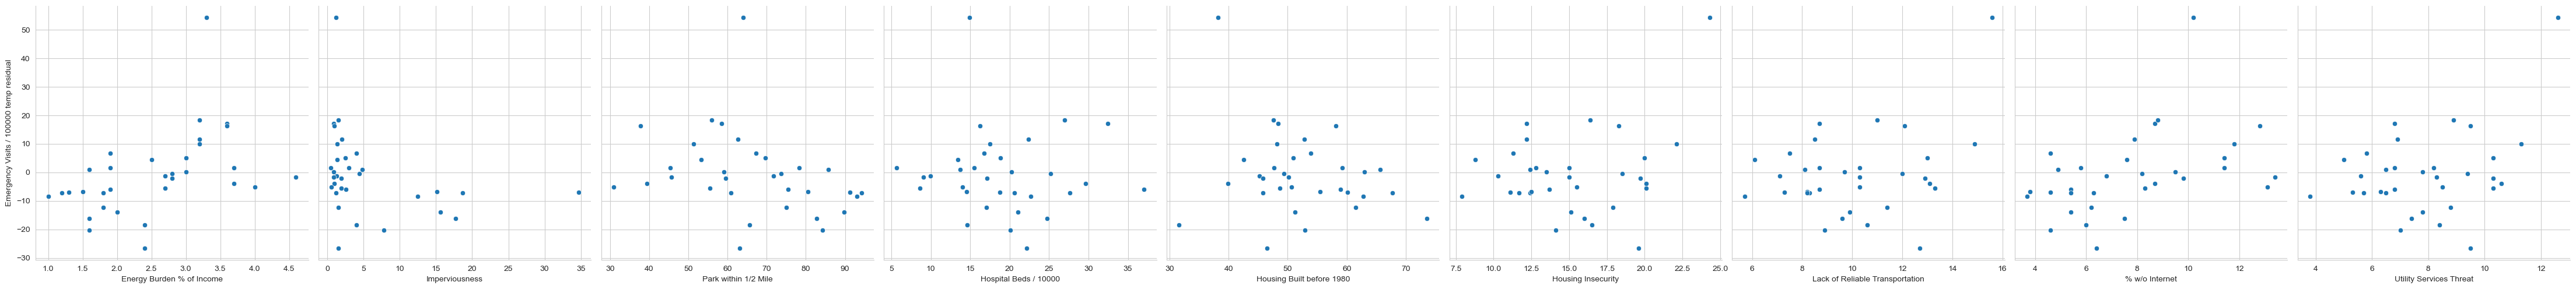

In [84]:
from sklearn.model_selection import train_test_split
county_train, county_test = train_test_split(
    county_df_residual, test_size=0.2, random_state=216, shuffle=True
)
features =county_train.columns[2:11]
print(features)
sns.pairplot(county_train,
    y_vars=["Emergency Visits / 100000 temp residual"],
    x_vars=features,
    height=5,
    diag_kind=None,
)

#sns.pairplot(data = county_train,
#                x_vars = features,
#                y_vars = features,
#                hue = county_train.columns[0],
#                plot_kws = {'alpha':.6})

plt.show()

In [85]:
county_df_residual[features].corrwith(county_df_residual['Emergency Visits / 100000 temp residual'])


Energy Burden % of Income          0.482810
Imperviousness                    -0.322461
Park within 1/2 Mile              -0.309783
Hospital Beds / 10000             -0.125220
Housing Built before 1980         -0.181212
Housing Insecurity                 0.181747
Lack of Reliable Transportation    0.229602
% w/o Internet                     0.438666
Utility Services Threat            0.273949
dtype: float64

Index(['Energy Burden % of Income', 'Imperviousness', 'Park within 1/2 Mile',
       'Hospital Beds / 10000', 'Housing Built before 1980',
       'Housing Insecurity', 'Lack of Reliable Transportation',
       '% w/o Internet', 'Utility Services Threat'],
      dtype='object')


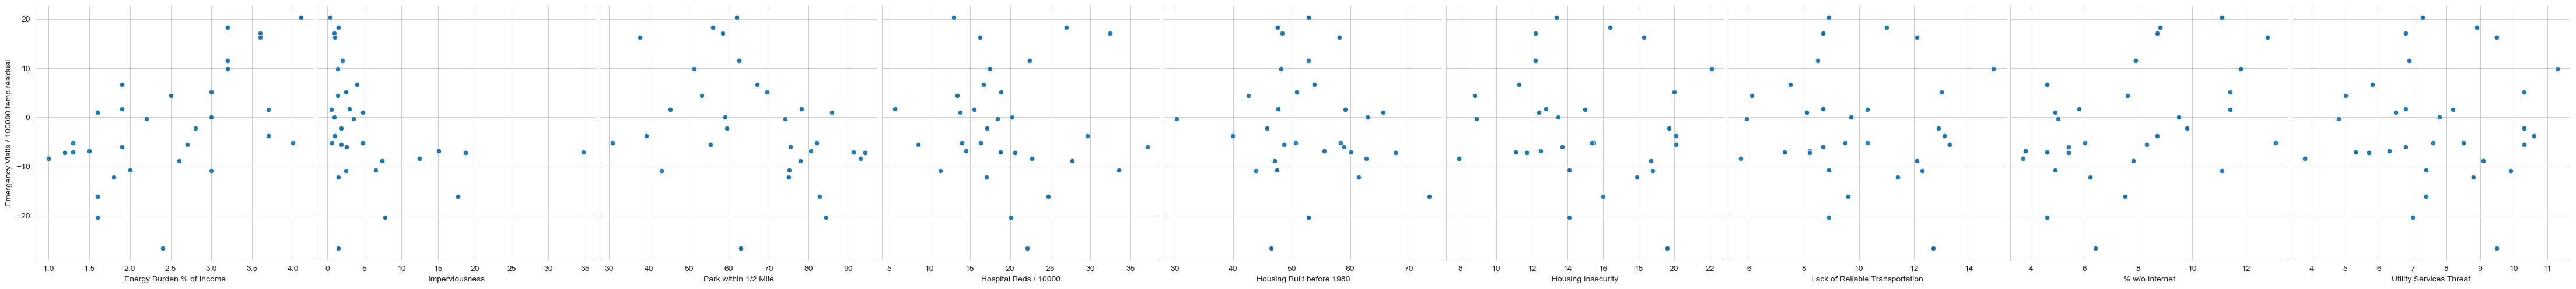

In [86]:
#Looking at this, I think it is very much affected by the outlier. I am going to try this, the outlier 

from sklearn.model_selection import train_test_split
county_df_noImperial = county_df_residual[county_df_residual['County'] != "Imperial"]

county_train, county_test = train_test_split(
    county_df_noImperial, test_size=0.2, random_state=216, shuffle=True
)
features =county_train.columns[2:11]
print(features)
sns.pairplot(county_train,
    y_vars=["Emergency Visits / 100000 temp residual"],
    x_vars=features,
    height=5,
    diag_kind=None,
)

#sns.pairplot(data = county_train,
#                x_vars = features,
#                y_vars = features,
#                hue = county_train.columns[0],
#                plot_kws = {'alpha':.6})

plt.show()

In [87]:
county_df_noImperial[features].corrwith(county_df_noImperial['Emergency Visits / 100000 temp residual'])


Energy Burden % of Income          0.521808
Imperviousness                    -0.349415
Park within 1/2 Mile              -0.386349
Hospital Beds / 10000             -0.093304
Housing Built before 1980         -0.035535
Housing Insecurity                -0.103054
Lack of Reliable Transportation   -0.026036
% w/o Internet                     0.460946
Utility Services Threat            0.019250
dtype: float64